In [67]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import io as io
import math
import copy
import scipy.signal as signal
from IPython.core.debugger import Tracer

rcdef = plt.rcParams.copy()
newparams_for_screen = {'axes.labelsize': 14, 'axes.linewidth': 0.75, 
                        'savefig.dpi': 100, 'lines.linewidth': 0.6, 
                        'figure.figsize': (8, 6), 'ytick.labelsize': 12, 
                        'xtick.labelsize': 12, 'axes.titlesize': 14,
                        'legend.fontsize': 10, 'legend.frameon': True,
                        'legend.handlelength': 1.5}
plt.rcParams.update(newparams_for_screen)

---

### Exercise 4.1 
Extend your 1-d finite-volume solver for advection (from Exercise 3.7) to solve Burgers' equation. Your will need to change the Riemann solver and use the local velocity in the construction of the interface states. Run the examples shown in Figures 4.3 and 4.4.

In [53]:
class Limiters:
    """All sorts of limtiers & return partial a / partial x"""
    
    
    def __init__(self):
        
        pass
        
    @classmethod    
    def given_data(cls, a, dx):
        """Overload constructor with given data"""
        
        self.update_data(a, dx)
    
    def update(self, a, dx):
        """Update data and compute common expressions"""
        
        self.a = a
        self.dx = dx
        self.a_left_value = np.roll(self.a, 1)
        self.a_right_value = np.roll(self.a, -1)
        self.papx_i_L = (self.a - self.a_left_value) / self.dx
        self.papx_i_R = (self.a_right_value - self.a) / self.dx
        self.papx_i_RL = \
            (self.a_right_value - self.a_left_value) / (2 * self.dx)
        self.papx_i = np.zeros(len(a))
        
    def _minmod(self, a, b):
        """Choose the smaller one from |a| & |b| if they have the same sign"""
        
        if (abs(a) < abs(b)) and (a*b > 0.0):
            return a
        elif (abs(b) < abs(a)) and (a*b > 0.0):
            return b
        else:
            return 0.0
        """Another version using ternary statement
        return 0.0 \
            if a*b < 0.0 \
            else \
                (a if abs(a) < abs(b) else b)                
        """
    
    def _maxmod(self, a, b):
        """Choose the larger one from |a| & |b| if they have the same sign"""
        
        if (abs(a) > abs(b)) and (a*b > 0.0):
            return a
        elif (abs(b) > abs(a)) and (a*b > 0.0):
            return b
        else:
            return 0.0
        
    def unlimit(self, a=None, dx=None):
        """No limiting, equivalent to central-difference"""
        
        if a is not None or dx is not None:
            self.update(a, dx)
            
        return self.papx_i_RL
    
    
    def minmod(self, a=None, dx=None):
        """Minmod method -- abandon steeper slope"""
        
        if a is not None or dx is not None:
            self.update(a, dx)
            
        for i in range(len(self.a)):
            self.papx_i[i] = self._minmod(self.papx_i_L[i], self.papx_i_R[i])
            
        return self.papx_i

    def MClimiter(self, a=None, dx=None):
        """MC limiter -- minmod with central-difference"""
        
        if a is not None or dx is not None:
            self.update(a, dx)        
        
        for i in range(len(self.a)):
            self.papx_i[i] = self._minmod(self._minmod(2*self.papx_i_L[i],
                                                       2*self.papx_i_R[i]),
                                          self.papx_i_RL[i])
        
        return self.papx_i

    def piecewise_constant(self, a=None, dx=None):
        """Piecewise Constant -- equivalent to non-limiting / godunov"""
        
        if a is not None or dx is not None:
            self.update(a, dx)
            
        return np.zeros(len(a))

    def superbee(self, a=None, dx=None):
        """SuperBee -- softening minmod"""
        
        if a is not None or dx is not None:
            self.update(a, dx)
        
        for i in range(len(a)):
            papx_i_A = self._minmod(self.papx_i_R[i], 2*self.papx_i_L[i])
            papx_i_B = self._minmod(self.papx_i_L[i], 2*self.papx_i_R[i])
            self.papx_i[i] = self._maxmod(papx_i_A, papx_i_B)
            
        return self.papx_i

class Profile1D:
    """Create a profile in 1D"""
    
    def __init__(self, N, shape, Nghost, BCs, xmin=0.0, xmax=1.0):
        
        # N = the # of finite-volume cells, default x belongs to [0,1]        
        self.x = (np.arange(N+2*Nghost)+0.5-Nghost) / N
        self.x = self.x * (xmax-xmin) + xmin
        self.dx = (xmax-xmin) / N
        self.t = 0.0
        self.a = np.zeros(N+2*Nghost)
        self.u = np.zeros(N+2*Nghost)
        self.Nghost = Nghost
        
        if shape == "Gaussian":
            self.a = signal.gaussian(N+2*Nghost, std=int(N/6))
        elif shape == "top-hat":
            index = np.logical_and(self.x >= 1./3., self.x <= 2./3.)
            self.a[index] = 1.0
        elif shape == "rarefaction":
            self.a[:] = 1.0
            self.a[self.x > 0.5] = 2.0
        elif shape == "sine":
            self.a[:] = 1.0
            index = np.logical_and(self.x >= 0.333, self.x <= 0.666)
            self.a[index] += \
                0.5*np.sin(2.0*math.pi*(self.x[index]-0.333)/0.333)
        else:
            print("Unrecognized shape")
        
        self.BCs = BCs
        self.apply_BCs()
        
    def apply_BCs(self):
        """Apply boundary conditions"""
        
        if self.BCs == "periodic":
            self.a[            :self.Nghost] = \
                                        self.a[-2*self.Nghost:-self.Nghost ]
            self.a[-self.Nghost:           ] = \
                                        self.a[self.Nghost   :2*self.Nghost]
            if hasattr(self.u, "__len__"):
                self.u[            :self.Nghost] = \
                                        self.u[-2*self.Nghost:-self.Nghost ]
                self.u[-self.Nghost:           ] = \
                                        self.u[self.Nghost   :2*self.Nghost]
        elif self.BCs == "outflow":
            self.a[            :self.Nghost] = self.a[self.Nghost]
            self.a[-self.Nghost:           ] = self.a[-self.Nghost-1]
            if hasattr(self.u, "__len__"):
                self.u[            :self.Nghost] = self.u[self.Nghost]
                self.u[-self.Nghost:           ] = self.u[-self.Nghost-1]

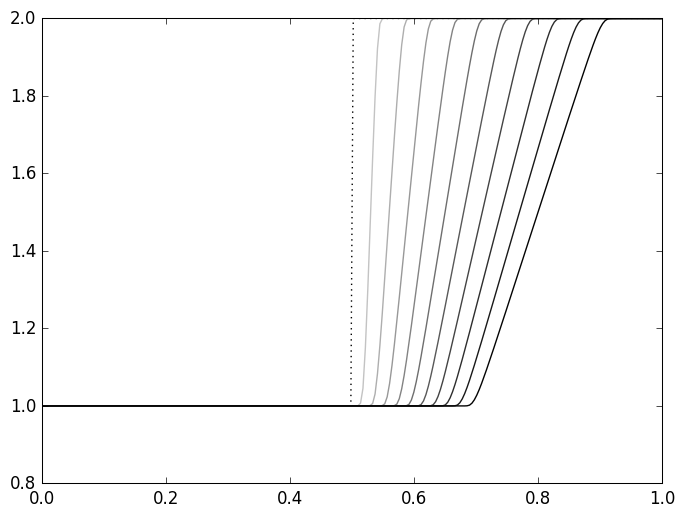

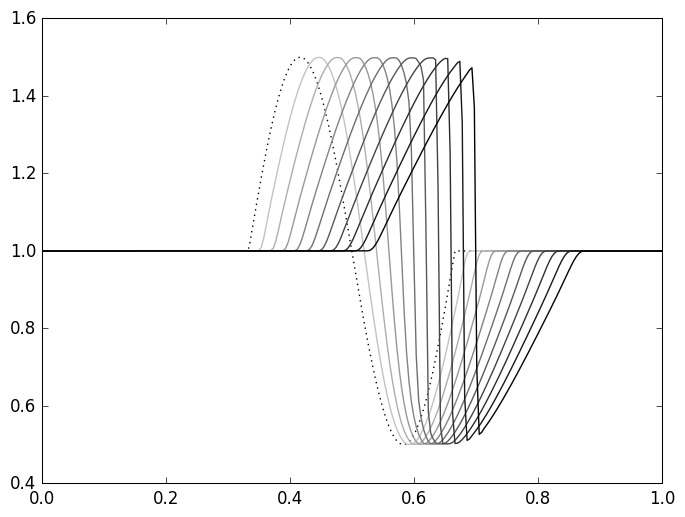

In [97]:
def cht_e4_1():
    """Code for Exercise 4.1"""
        
    def onestep(pf, C):
        """Forward the profile one step"""
        
        u_left_value = np.roll(pf.u, 1)
        u_right_value = np.roll(pf.u, -1)
        pupx_i = Limiters().MClimiter(pf.u, pf.dx)
        
        #
        #  --+-----------------+------------------+
        #     ^       i       ^ ^        i+1
        #     ur(i)     ul(i+1) ur(i+1)
        #
        
        u_interface_left = u_left_value + 0.5*pf.dx \
            * (1-pf.dt/pf.dx*u_left_value)*np.roll(pupx_i, 1)
        u_interface_right = pf.u - 0.5*pf.dx * (1+pf.dt/pf.dx*pf.u)*pupx_i
        
        # Now solve Riemann problem
        S = 0.5 * (u_interface_left+u_interface_right)
        u_shock = np.where(S > 0.0, 
                           u_interface_left, u_interface_right)
        u_shock = np.where(S == 0.0, 0.0, u_shock)

        u_rare = np.where(u_interface_left > 0.0, 
                          u_interface_left, 0.0)
        u_rare = np.where(u_interface_right < 0.0,
                          u_interface_right, u_rare)
        u_flux = np.where(u_interface_left > u_interface_right,
                          u_shock, u_rare)
        #Tracer()() #this one triggers the debugger
        f_left = 0.5 * u_flux * u_flux
        f_right = np.roll(f_left, -1)
        pf.u = pf.u + pf.dt/pf.dx * (f_left-f_right)
        pf.apply_BCs()

    def update(pf, tlim, C):
        """Update a profile till t=tlim"""

        pf.dt = C * pf.dx / max(abs(pf.u))
        #Tracer()() #this one triggers the debugger
        while pf.t + pf.dt < tlim:
            onestep(pf, C)
            pf.t += pf.dt
            pf.dt = C * pf.dx / max(abs(pf.u))
        pf.dt = tlim - pf.t
        onestep(pf, C)        
                
    def compare(N, shape, BCs, tlim):
        """Compare simple simulations"""
        
        fig = plt.figure(1)
        ax = fig.add_subplot(111)
        C = 0.8
        
        for temp_tlim in np.linspace(0.0, tlim, 11):
            pf = Profile1D(N, shape, 2, BCs)
            pf.u = pf.a
            update(pf, temp_tlim, C)
            ls = '-' if temp_tlim != 0.0 else ':'
            co = str(0.85-0.84*temp_tlim/tlim) if temp_tlim != 0.0 else '0'
            ax.plot(pf.x, pf.u, label=shape, lw=1, linestyle=ls,
                    color=co)

        ax.set_xlim([0.0, 1.0])
        plt.show()
        plt.close("all")
        
    compare(256, "rarefaction", "outflow", 0.2)
    compare(256, "sine", "periodic", 0.2)

cht_e4_1()